In [1]:
import pandas as pd
import numpy as np
import csv 
import matplotlib.pyplot as plt
import spacy
import math
import os
import statsmodels.api as sm

from src.utils import *
from src.data_preprocessing import *
from src.data_processing import *
from src.feature_selection import *
from src.modelisation_arcticle_1 import *
from src.modelisation_arcticle_2 import *

os.chdir('/Users/ismailakrout/Desktop/python/NLP_statapp')

pd.set_option("display.max_columns", None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ismailakrout/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ismailakrout/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# pour ne pas charger le NB avec des warnings 
import warnings 
warnings.filterwarnings('ignore')

## Pour les journaux

In [3]:
df_daily_express = pd.read_csv('00. input/new_bigfive_DailyExpress_with_sentibert_post2010.csv', encoding='utf-8')
df_the_guardian = pd.read_csv('00. input/newSplit_topics_bigfive_theGuardian_with_sentibert_post2010.csv', encoding='utf-8')

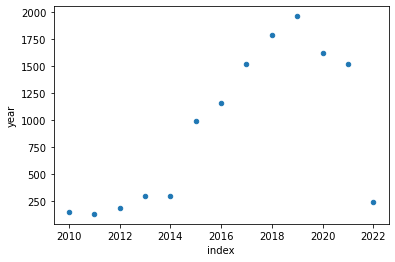

In [4]:
aux_graphique_daily = pd.DataFrame(df_daily_express['year'].value_counts()).reset_index().sort_values(by=['index'])
aux_graphique_daily.plot(x='index', y='year', kind='scatter')
plt.show()

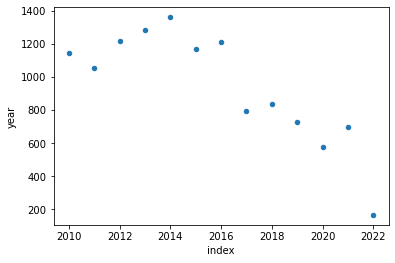

In [5]:
aux_graphique_guardian = pd.DataFrame(df_the_guardian['year'].value_counts()).reset_index().sort_values(by=['index'])
aux_graphique_guardian.plot(x='index', y='year', kind='scatter')
plt.show()

In [6]:
df_daily_express = df_daily_express[['year', 'fulltext']]
df_daily_express['party'] = 'Con'


In [7]:
df_the_guardian = df_the_guardian[['year', 'fulltext']]
df_the_guardian['party'] = 'Lab'


In [8]:
df = pd.concat([df_daily_express, df_the_guardian])
df.rename(columns={
    'fulltext': 'text'
}, inplace=True)

In [9]:
# df = df.sample(frac=1)
# df = df[:1000]

In [10]:
# il faut une minute pour 1000 lignes
# donc il me faudra 30 minutes pour faire tourner avec toute la base 
# puis je fais le calcul des fréquences
 
df['text'] = df['text'].apply(clean, args=('bigram',))


In [11]:
df_freqs_Con = count_freqs(df, 'Con')

In [ ]:
df_freqs_Lab = count_freqs(df, 'Lab')

In [ ]:
df_freqs = merge_freq(df_freqs_Con, df_freqs_Lab)

In [ ]:
df_freqs = df_freqs.loc[(df_freqs['freq_Con'].notna()) & (df_freqs['freq_Lab'].notna())]

In [ ]:
df_freqs['freq'] = df_freqs['freq_Con'] + df_freqs['freq_Lab']

In [ ]:
df_freqs = df_freqs.sort_values(by=['freq'], ascending=False).reset_index(drop=True)

In [ ]:
df_freqs

,words,freq_Con,freq_Lab,freq
0,social media,1700.0,4078.0,5778.0
1,last year,2410.0,3101.0,5511.0
2,thi year,2897.0,2290.0,5187.0
3,xbox one,4185.0,419.0,4604.0
4,oper system,2746.0,1531.0,4277.0
...,...,...,...,...
420798,societi anyway,1.0,1.0,2.0
420799,muslim member,1.0,1.0,2.0
420800,tag kept,1.0,1.0,2.0
420801,way reconnect,1.0,1.0,2.0


In [ ]:
df_freqs.to_csv('01. output/df_freqs_article_06_05_23.csv')

In [4]:
df_freqs = pd.read_csv('01. output/df_freqs_article_06_05_23_s.csv')

In [6]:
df_freqs = df_freqs.sort_values(by=['freq'], ascending=False)
df_freqs.head(5000)

,Unnamed: 0,words,freq_Con,freq_Lab,freq
0,0,social media,1700.0,4078.0,5778.0
1,1,last year,2410.0,3101.0,5511.0
2,2,thi year,2897.0,2290.0,5187.0
3,3,xbox one,4185.0,419.0,4604.0
4,4,oper system,2746.0,1531.0,4277.0
...,...,...,...,...,...
5010,5010,us law,7.0,84.0,91.0
5009,5009,sound good,42.0,49.0,91.0
5008,5008,howev appear,83.0,8.0,91.0
5007,5007,also know,45.0,46.0,91.0


In [ ]:
list_of_words = selected_words(df_freqs)

In [ ]:
df = construct_df_reg(df, df_freqs, list_of_words)

In [ ]:
df.to_csv('01. output/df_reg_article_5000_06_05_23.csv')

In [37]:
df = pd.read_csv('01. output/df_reg_article_5000_06_05_23_s.csv')

In [38]:
X_train = df.iloc[:, 4:].values

In [39]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [2, 1, 0, ..., 0, 0, 0],
       [3, 1, 0, ..., 0, 0, 0]])

In [40]:
from sklearn.decomposition import PCA

In [43]:
pca = PCA(n_components = 5000)
X_train_bis = pca.fit_transform(X_train)

In [46]:
(pca.explained_variance_ratio_).cumsum()

array([0.02592506, 0.04630195, 0.06173021, ..., 0.99999927, 0.99999964,
       1.        ])

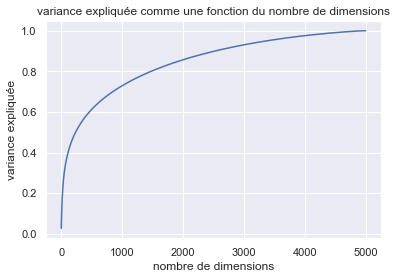

In [51]:
import matplotlib.pyplot as plt

# Define x and y values
x = [k for k in range(1,5001)]
y = (pca.explained_variance_ratio_).cumsum()

# Plot the graph
plt.plot(x, y)

# Set the axis labels and title
plt.xlabel('nombre de dimensions')
plt.ylabel('variance expliquée')
plt.title('variance expliquée comme une fonction du nombre de dimensions')

# Show the graph
plt.show()

In [44]:
(pca.explained_variance_ratio_).sum()

1.0

En gardant 500 features on réussit à contenir 60 pour cent de la variance du modèle 

In [9]:
df_PCA = pd.DataFrame(X_train_bis, columns=[f'feature{i}' for i in range(1,501)]).reset_index()

In [10]:
df = df.reset_index(drop=True).reset_index()

In [11]:
df.columns

Index(['index', 'Unnamed: 0', 'year', 'text', 'party', 'social media',
       'last year', 'thi year', 'xbox one', 'oper system',
       ...
       'compani onli', 'never know', 'flight simul', 'owner use',
       'question wa', 'us law', 'sound good', 'howev appear', 'also know',
       'allow access'],
      dtype='object', length=5005)

In [12]:
df_with_500_features = pd.merge(
    df[['index', 'year', 'text', 'party']],
    df_PCA,
    how='left',
    on=['index']
)

In [13]:
df_with_500_features.drop(columns=['index'], inplace=True)

In [14]:
df_with_500_features.to_csv('01. output/df_ACP_article_500_06_05_23.csv')

In [15]:
df_with_500_features = pd.read_csv('01. output/df_ACP_article_500_06_05_23.csv')

In [16]:
df_with_500_features['Y'] = (df_with_500_features['party'] == 'Con').astype(int)

In [17]:
df_with_500_features

,Unnamed: 0,year,text,party,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature142,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature190,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225,feature226,feature227,feature228,feature229,feature230,feature231,feature232,feature233,feature234,feature235,feature236,feature237,feature238,feature239,feature240,feature241,feature242,feature243,feature244,feature245,feature246,feature247,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature257,feature258,feature259,feature260,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature314,feature315,feature316,feature317,feature318,feature319,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature360,feature361,feature362,feature363,feature364,feature365,feature366,feature367,feature368,feature369,feature370,feature371

In [18]:
df_with_500_features.drop(columns=['Unnamed: 0', 'year', 'text', 'party'], inplace=True)

In [19]:
df_with_500_features = df_with_500_features.sample(frac=1).reset_index(drop=True)

In [20]:
df_with_500_features

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature142,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature190,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225,feature226,feature227,feature228,feature229,feature230,feature231,feature232,feature233,feature234,feature235,feature236,feature237,feature238,feature239,feature240,feature241,feature242,feature243,feature244,feature245,feature246,feature247,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature257,feature258,feature259,feature260,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature314,feature315,feature316,feature317,feature318,feature319,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature360,feature361,feature362,feature363,feature364,feature365,feature366,feature367,feature368,feature369,feature370,feature371,feature372,feature373,feat

In [2]:
# Import necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('01. output/df_reg_article_5000_06_05_23_s.csv')
df['Y'] = (df['party'] == 'Con').astype(int)

In [5]:
# Load dataset
X = df.iloc[:, 4:5004]
y = df['Y']

In [6]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [7]:
# Standardize the dataset                                             
scaler = StandardScaler()
# Fit on the train set only
scaler.fit(X_train)
# Apply to both the train set and the test set. 
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# Apply PCA
pca = PCA(n_components = 500)
# Fit on the train set only
pca.fit(X_train)
# Apply transform to both the train set and the test set. 
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [11]:
X_test.shape

(4817, 500)

In [12]:
# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Define SVM model
svm = SVC(kernel='linear', C=1)

# Train SVM model
svm.fit(X_train, y_train)

# Predict labels for test set
y_pred = svm.predict(X_test)

# Evaluate performance of SVM model
accuracy = svm.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.8860286485364335


In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred) 

array([[2285,  185],
       [ 364, 1983]])

In [36]:
len(pca.explained_variance_ratio_)

500

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8758563421216525
RandomForestClassifier 0.8374506954536018
SVC 0.8764791363919452
VotingClassifier 0.8895578160680921


,feature1,feature2,feature3,Y
0,-0.315137,-0.124264,-0.409348,0
1,-0.115809,0.088029,-0.217766,1
2,-0.222549,-0.066619,-0.300952,1
3,-0.128913,-0.041551,-0.266223,1
4,-0.198991,-0.118525,-0.218935,1
...,...,...,...,...
24078,0.293063,-0.327952,-0.268929,1
24079,-0.229988,-0.053336,-0.309868,0
24080,-0.232783,-0.083074,-0.271094,0
24081,-0.244691,-0.186165,0.405314,0


In [31]:
import seaborn as sns

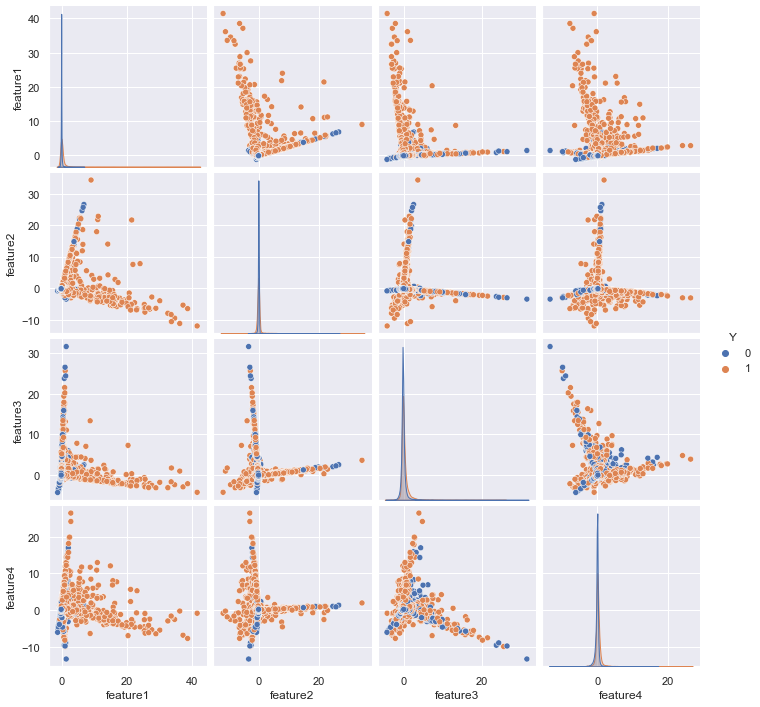

In [33]:
sns.set()
sns.pairplot(df_with_500_features[['feature1', 'feature2', 'feature3', 'feature4', 'Y']], hue="Y")
plt.show()

In [24]:
X = df_with_500_features.iloc[:, :10]
y = df_with_500_features['Y']

In [25]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [26]:
from sklearn.linear_model import LogisticRegression

LogitReg = LogisticRegression()

# train logistic regression model
LogitReg.fit(X_train, y_train)

# predicts labels for test sets
y_predict = LogitReg.predict(X_test)

# evaluate performances of logistic regression models 
accuracy = LogitReg.score(X_test, y_test)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
from sklearn.ensemble import RandomForestClassifier

rd_forest = RandomForestClassifier()

# train the random forest model 
rd_forest.fit(X_train, y_train)

# we predict the values thanks to the random forest model 
y_pred = rd_forest.predict(X_test)

# Remarque : on n'utilise pas le pred pour aplliquuer la fonction de score
# we evaluate the accuracy of our model thanks to the score function 
accuarcy = rd_forest.score(X_test, y_test)

print(accuracy)

0.7413327797384264
